In [34]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import h5py
import os
import re
from IPython.display import display, Audio

In [35]:
df = pd.read_csv\
('/green-projects/project-sonyc_redhook/workspace/share/redhook-analysis/output/max_dataframe_cut.csv')

In [36]:
df.head()

,Unnamed: 0,start_timestamp,frame,actual_timestamp,area,probability
0,10,1573061868,648,1573061911,276490,0.988503
1,32,1573830164,72,1573830168,207648,0.995947
2,45,1573830164,1518,1573830265,294148,0.969995
3,64,1573830554,72,1573830558,103700,0.983073
4,70,1573830554,190,1573830566,122512,0.977682


In [37]:
def show_frame(video_file, frame_number):
    vid_obj = cv2.VideoCapture(video_file)
    vid_obj.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    res, frame = vid_obj.read()
    if res:
        cropped_frame = frame[200:850, 1100:1750]
        return cropped_frame
    else:
        return False

In [38]:
h5 = h5py.File\
('/green-projects/project-sonyc_redhook/workspace/share/redhook-analysis/output/max_img.hdf5', 'r')

In [39]:
list(h5.keys())

['max_img']

In [40]:
max_img = h5['max_img']

In [41]:
max_img.dtype

dtype([('start_timestamp', '<f8'), ('frame', '<i8'), ('actual_timestamp', '<f8'), ('area', '<f8'), ('probability', '<f8'), ('img', '<i8', (650, 650, 3))])

In [11]:
max_idx = max_img.shape[0]

In [30]:
target_timestamp = max_img[6000]['actual_timestamp']

In [25]:
actual_timestamps = []
for idx in range(max_idx):
    actual_timestamps.append(max_img[idx]['actual_timestamp'])

In [26]:
actual_timestamps = np.array(actual_timestamps)

In [28]:
len(actual_timestamps)

7106

In [31]:
#take the 0th element just in case there are multiple matches
row = max_img[actual_timestamps == target_timestamp][0]

In [60]:
np.where(actual_timestamps == target_timestamp)

(array([6000]),)

Loop through files with truck audio, put all of the files in an array

In [42]:
truck_audio_files = []

In [43]:
for root, dirs, files in \
os.walk("/green-projects/project-sonyc_redhook/workspace/share/truck_audio/redhook_truck_audio"):
    for name in files:
        print(dirs)
        truck_audio_files.append(name)
        #use when checking timestamps
        #truck_audio_timestamps.append(int(re.split("_",name)[0]))

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [62]:
len(truck_audio_files)

2934

In [64]:
truck_audio_files[0]

'1573481602_88376.wav'

In [35]:
max_img[0][0]

1573061868.0

In [ ]:
#will eventually have list of wav files, named with the actual time, in an array
#then we will use a boolean mask to only annotate the files with corresponding audio
#will access the audio files using their timestamp, from the audio list (iloc? loc? boolean mask?)

In [95]:
truck_audio_files[0]

'1573481602_88376.wav'

In [14]:
def switch_color(img):
    """
    Switches the colors of an image from BGR format to RGB format.
    
    Parameters
    ----------
    img : ndarray
        An array representing an image, of the shape (x, x, 3). The array is in BGR format. 
        
    Returns
    -------
    switched_img : ndarray
        An array representing an image, of the shape (x, x, 3). The array is in RGB format.
    """
    #cv2 images are in bgr order, need to convert to rgb
    for i in range(len(img)):
        for j in range(len(img)):
            rgb_arr = img[:][i][j]
            #swapping r with b
            rgb_arr[0], rgb_arr[2] = rgb_arr[2], rgb_arr[0]
    return img

In [15]:
def annotate_img(img_arr, idx_arr, annotation_list, audio_arr):
    """
    Displays an interface for annotating images to indicate whether there is a truck or not. The function
    then stores the annotations and the respective indices of the images in an array. The function loops 
    through the audio array and displays the corresponding image.
    
    Parameters
    ----------
    img_arr : array
        Array containing the image array inside. The image array should be in the 5th column of img_arr.
        
    idx_arr : array
        Array containing the indices of audio_list to display for annotation. 
        
    annotation_list : array
        Array to append both the annotations for the images and the indices of the images in img_arr.
        It will be an array of tuples, each tuple containing a timestamp and the annotation
        
    audio_arr : array
        Array containing filenames of audio to match to corresponding images in img_arr
    """
    #loop through the folders in redhook_truck_audio, get folder and file name
    for folder in \
    os.listdir('/green-projects/project-sonyc_redhook/workspace/share/truck_audio/redhook_truck_audio'):
        for file in os.listdir\
        ('/green-projects/project-sonyc_redhook/workspace/share/truck_audio/redhook_truck_audio/' + folder):
            audio_timestamp = int(re.split("_", file)[0])
            
    #use audio timestamp to get corresponding image 
    match_row = max_img[actual_timestamps == audio_timestamp][0]
    
    #display img
    plt.imshow(switch_color(max_row['img']))
    plt.show()
    
    #play 1 second clip of audio (for this simple indexing of the audio list to work, we need to make sure
    #the audio list corresponds with the masked list)
    print('One-second audio clip corresponding to the image')
    display(Audio(filename=\
    '/green-projects/project-sonyc_redhook/workspace/share/truck_audio/redhook_truck_audio/' + \
    folder + '/' + file))
    
    clip = input("Press y if you would like to listen to the ten-second audio clip and n if not: ")
    
    if clip == 'y':
        print('Ten-second audio clip corresponding to the image')
        #to be added
    
    #truck or no? not sure?
    annotation = input("Press y if the image shows a truck, and n if not. Press m if you are unsure: ")
        
    #add answer to annotation_list
    annotation_list.append((match_row['actual_timestamp'], annotation)

In [16]:
test_annotation_list = []

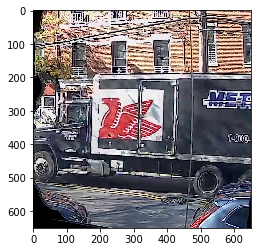

Press y if the image shows a truck, and n if not: y


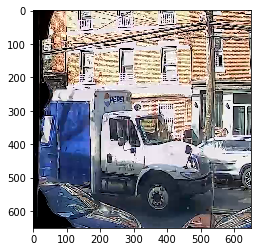

Press y if the image shows a truck, and n if not: y


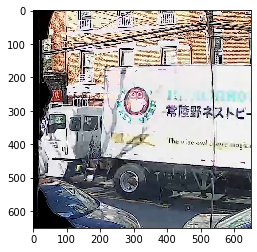

Press y if the image shows a truck, and n if not: y


In [17]:
annotate_img(max_img, [0, 1, 2], test_annotation_list)

In [20]:
max_img[0][2]

1573061911.0

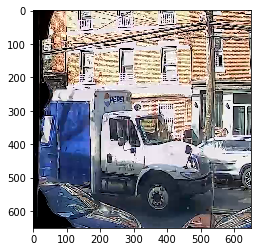

In [225]:
plt.imshow(switch_color(max_img[1][5]))